In [1]:
from numpy.random import seed
seed(1)
import numpy as np
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import os
import h5py
import scipy.io as sio
import cv2
import glob
import gc
import tensorflow as tf
from tensorflow import keras

from keras.models import load_model, Model, Sequential
from keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
		 	  Activation, Dense, Dropout, ZeroPadding2D)
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from keras.layers.advanced_activations import ELU
from tensorflow.keras.applications import EfficientNetB0

from utils import preprocess_image

data_folder = 'URFD_opticalflow/'
mean_file = 'flow_mean.mat'
vgg_16_weights = 'weights.h5'
best_model_path = 'VGG16_best_model/' #directory to store best model
fold_best_model_path = '' #to be determined by k-fold cross validation

learning_rate = 0.0001
mini_batch_size = 32
weight_0 = 1
epochs = 10
learning_rate = 0.0001
training_ratio = 0.8 #portion of data used for training and valuation
test_ratio = 0.2 #portion of data used for testing
threshold = 0.5 # Threshold to classify between positive and negative
total_num_folds = 4

In [2]:
num_features = 4096
model = Sequential()
print("Model", type(model))

model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 20)))
model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(num_features, name='fc6',
        kernel_initializer='glorot_uniform'))
#print(model.layers[-1].output_shape)

# ========================================================================
# WEIGHT INITIALIZATION
# ========================================================================
layerscaffe = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1',
        'conv3_2', 'conv3_3', 'conv4_1', 'conv4_2', 'conv4_3',
        'conv5_1', 'conv5_2', 'conv5_3', 'fc6', 'fc7', 'fc8']
h5 = h5py.File(vgg_16_weights, 'r')

layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Copy the weights stored in the 'vgg_16_weights' file to the
# feature extractor part of the VGG16
for layer in layerscaffe[:-3]:
    w2, b2 = h5['data'][layer]['0'], h5['data'][layer]['1']
    w2 = np.transpose(np.asarray(w2), (2,3,1,0))
    w2 = w2[::-1, ::-1, :, :]
    b2 = np.asarray(b2)
    layer_dict[layer].set_weights((w2, b2))
    layer_dict[layer].trainable = False

# Copy the weights of the first fully-connected layer (fc6)
layer = layerscaffe[-3]
w2, b2 = h5['data'][layer]['0'], h5['data'][layer]['1']
w2 = np.transpose(np.asarray(w2), (1,0))
b2 = np.asarray(b2)
layer_dict[layer].set_weights((w2, b2))
layer_dict[layer].trainable = False

adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999,
    epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy',
        metrics=['accuracy'])


Model <class 'tensorflow.python.keras.engine.sequential.Sequential'>


In [3]:
extracted_features = model.output
print(extracted_features)

KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='fc6/BiasAdd:0', description="created by layer 'fc6'")


In [4]:
img_width = 224
img_height = 224

In [5]:
# # making model w/o the top layers
# model_nfc = Sequential()
# for layer in model.layers[:-2]: # go through until last layer
#     model_nfc.add(layer)



In [30]:
model = keras.applications.VGG16(weights = 'imagenet', include_top = False )

print(model.summary())
#layer_name = 'conv2_1'
#layer_name = 'conv3_block4_out'
layer_name = 'block3_conv1'

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [31]:
#model = keras.applications.ResNet50V2(weights = 'imagenet', include_top = False)
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs = model.inputs, outputs = layer.output)
#print(model_nfc.inputs)
#print(layer.output)

In [8]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [9]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [10]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1 , img_width, img_height, 3))
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25

def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

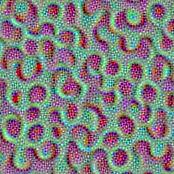

In [32]:
from IPython.display import Image, display
import PIL
loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("pp.jpg", img)

display(Image("pp.jpg"))

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

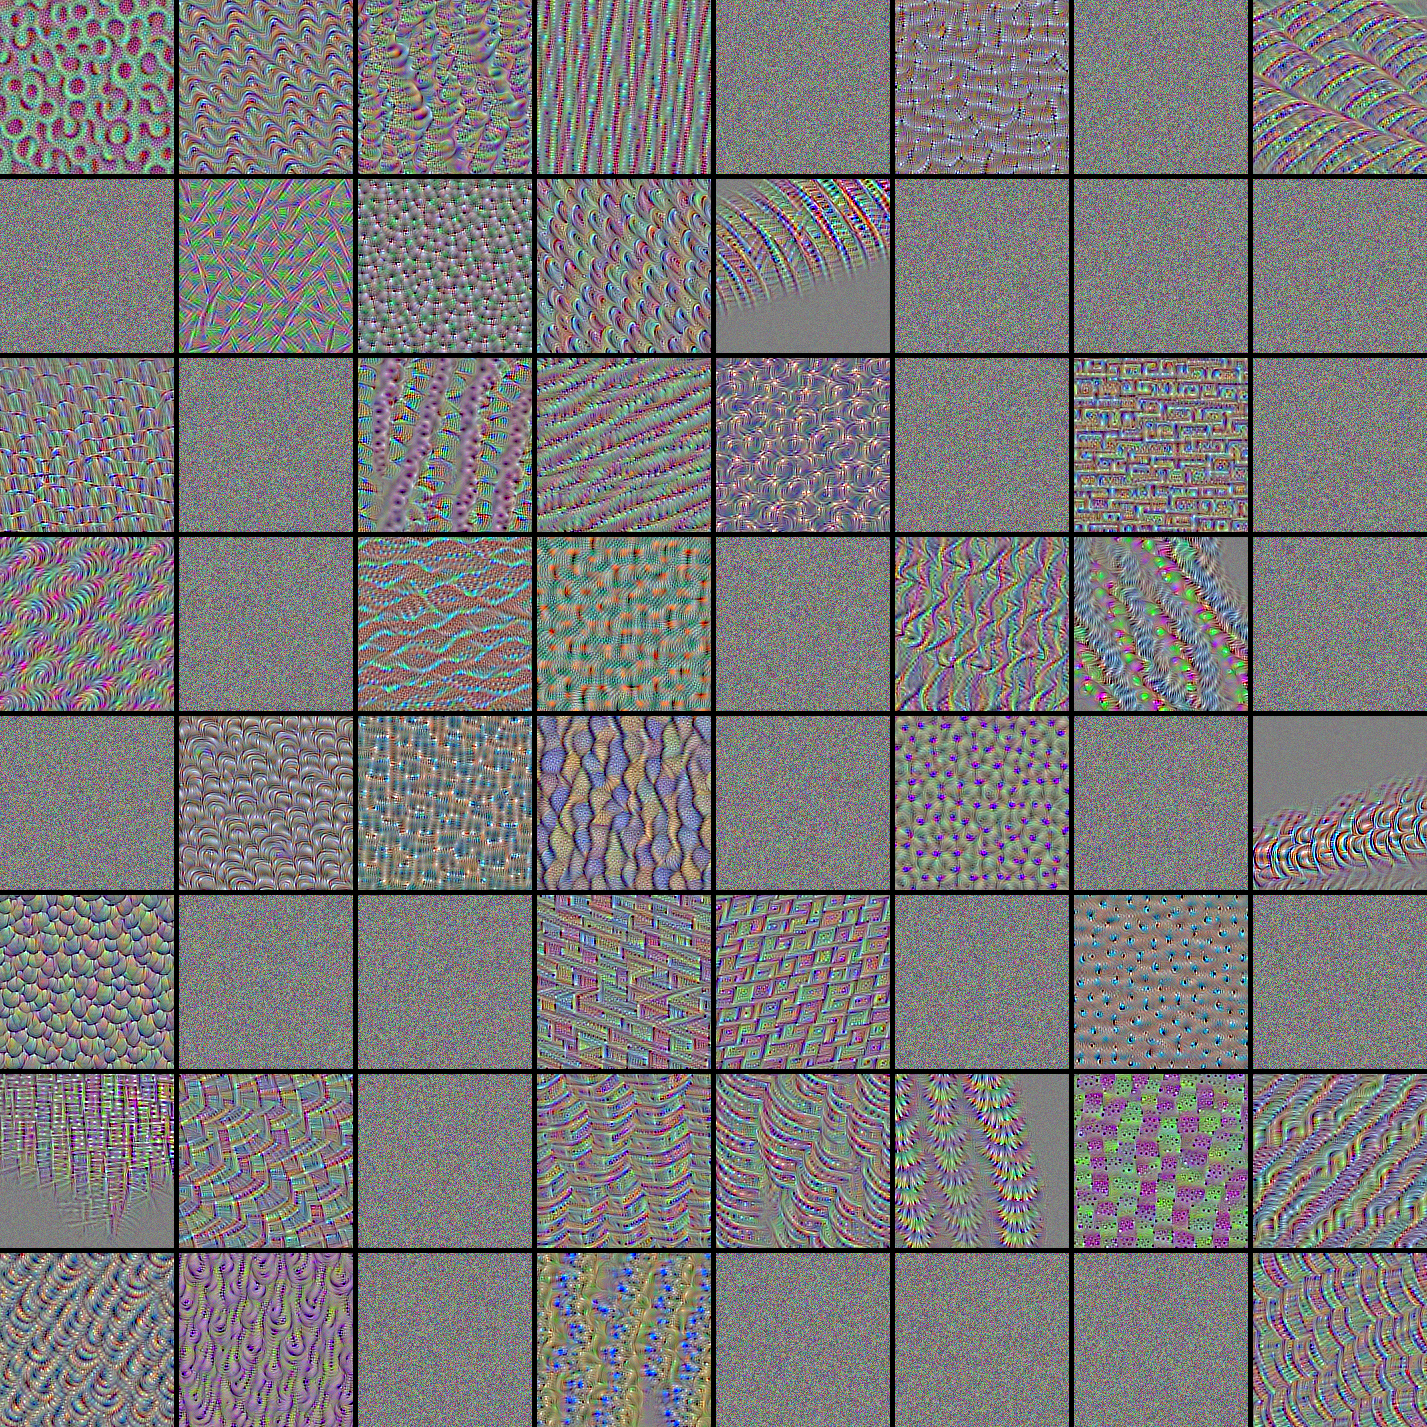

In [33]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))